In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  8 15:08:44 2022

@author: Wenhao Hsu
"""
from rdkit.Chem import AllChem
from rdkit import Chem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# get data set from filepath and do the data cleaning
dataset_path = './data/csv/washed_data_train.csv'
df = pd.read_csv(dataset_path)
df = df.dropna(subset=['lambda_onset'])
df = df.reset_index(drop=True)
print('\nImported data from '+ dataset_path+', shape: '+str(np.shape(df)))


Imported data from ./data/csv/washed_data_train.csv, shape: (292, 46)


In [3]:
# generate the morgan fingerprints and append it to dataframe
x = df['SMILES']
y = pd.DataFrame(df['lambda_onset'])
y = np.ravel(y)
print('The shape of morgan-finger print as array x          : '+str(np.shape(x)))
print('The shape of feature as array y                      : '+str(np.shape(y)))

The shape of morgan-finger print as array x          : (292,)
The shape of feature as array y                      : (292,)


In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt


def show_error_plot(y_test,y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()

In [5]:

from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin, _OneToOneFeatureMixin
from sklearn.metrics import mean_absolute_percentage_error
def get_fp_mat( SMILES_list, r = 2, nBits =2048,func = AllChem.GetMorganFingerprintAsBitVect):
    """
    do: generate the morgan-fingerprints and save it as matrix
    SMILES_list: The list of SMILES string
    OUTPUT: morgan-fingerprints matrix
    """
    fps = []
    for SMILES_string in SMILES_list:
        mol = Chem.MolFromSmiles(SMILES_string)
        if func == AllChem.GetMorganFingerprintAsBitVect:
            fp = func(mol,r,useFeatures=False, nBits=nBits).ToBitString()
            fps.append(fp)
        elif func == Chem.RDKFingerprint:
            fp = func(mol = mol,maxPath = r, fpSize=nBits).ToBitString()
            fps.append(fp)
    bits = []
    for fp in fps:
        bit_list = []
        for bit in fp:
            bit_list.append( int(bit) )
        bits.append(bit_list)
    return bits

class fp4knn(BaseEstimator,TransformerMixin): # fingerprints for knn
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        output = pd.DataFrame(get_fp_mat(X,r = 6,nBits = 2048,func=Chem.RDKFingerprint))
        output['Mol.wt'] = df['Mol.wt']
        return output
class fp4ridge(BaseEstimator,TransformerMixin): # fingerprints for ridge
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        output = pd.DataFrame(get_fp_mat(X,r = 6,nBits = 2560,func=Chem.RDKFingerprint))
        output['Mol.wt'] = df['Mol.wt']
        return output
class fp4lasso(BaseEstimator,TransformerMixin): # fingerprints for lasso
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X,y=None):
        output = pd.DataFrame(get_fp_mat(X,r = 4,nBits = 2560,func=AllChem.GetMorganFingerprintAsBitVect))
        output['Mol.wt'] = df['Mol.wt']
        return output


In [7]:
def get_ensemble(): # define the base models
	models = list()
	knn_pipeline = Pipeline([('get_fp', fp4knn()), ('ss', StandardScaler()), ('knn', KNeighborsRegressor())])
	models.append(('knn', knn_pipeline))
	ridge_pipeline = Pipeline([('get_fp', fp4ridge()), ('ridge', Ridge())])
	models.append(('ridge', ridge_pipeline))
	lasso_pipeline = Pipeline([('get_fp', fp4lasso()), ('ss', StandardScaler()), ('lasso', Lasso())])
	models.append(('lasso', lasso_pipeline))
	ensemble = VotingRegressor(estimators=models) # define the voting ensemble
	return models + [('ensemble', ensemble)] # return a list of tuples each with a name and model

x = df['SMILES'].to_list()
models = get_ensemble()
results_mape = list()
for name,model in models:
	x_train, x_test, y_train, y_test = train_test_split( x, y,test_size=0.2,random_state=2022)
	model.fit(x_train,y_train)
	y_pred=model.predict(x_test)
	score=model.score(x_test,np.ravel(y_test))
	score_train=model.score(x_train,np.ravel(y_train))
	print('\n'+name)
	# show_error_plot(y_test,y_pred)
	MAPE = mean_absolute_percentage_error(y_test,y_pred)
	print(' 得分：'+str(score)+' MAPE：'+str(MAPE)+'训练集相关系数：'+str(score_train))
	results_mape.append(MAPE)


knn
 得分：0.6005951097794389 MAPE：0.036898885479093244训练集相关系数：0.6941500462114323

ridge
 得分：0.7026962466041466 MAPE：0.031732868878970664训练集相关系数：0.995998663286318

lasso
 得分：0.4637567418058104 MAPE：0.040544885967509464训练集相关系数：0.976253905234418

ensemble
 得分：0.7155685948288174 MAPE：0.03029726604747488训练集相关系数：0.9499736623675709


学习曲线

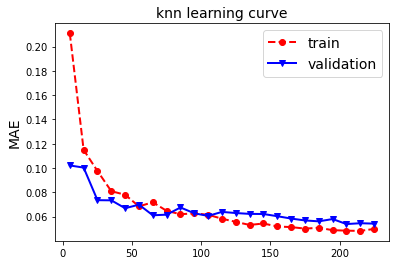

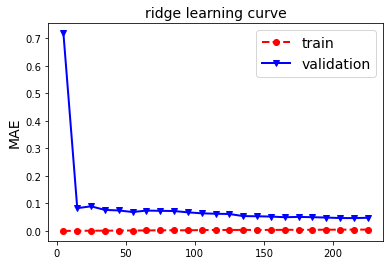

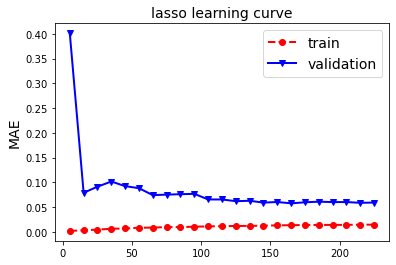

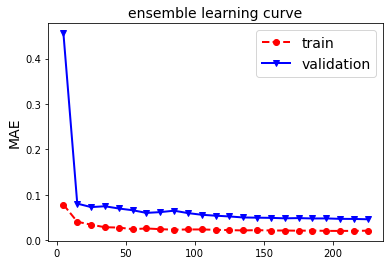

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

for name,model in models:
    x_train, x_test, y_train, y_test = train_test_split( x, y,test_size=0.2,random_state=2022)
    model=model
    train_errors, test_errors = [], []
    for m in range(5, len(x_train),10):
        model.fit(x_train[:m], np.ravel(y_train[:m]))
        y_train_predict = model.predict(x_train[:m])
        y_test_predict = model.predict(x_test)
        train_errors.append(np.mean(np.abs(np.ravel(1240/y_train_predict)-np.ravel(1240/y_train[:m]))))
        #test_errors.append(mean_squared_error(y_test_predict, y_test))
        test_errors.append(np.mean(np.abs(np.ravel(1240/y_test_predict)-np.ravel(1240/y_test))))
    pd.DataFrame(train_errors).to_excel('./data/xlsx/learning_curve_train_errors'+name+'.xlsx',index=None,header=None)
    pd.DataFrame(test_errors).to_excel('./data/xlsx/learning_curve_test_errors'+name+'.xlsx',index=None,header=None)
    plt.plot(range(5, len(x_train),10), train_errors, "r--o", linewidth=2, label="train")
    plt.plot(range(5, len(x_train),10), test_errors, "b-v", linewidth=2, label="validation")
    #plt.legend(loc="upper right", fontsize=14)
    #plt.xlabel("189 Training set size", fontsize=14)
    plt.ylabel("MAE", fontsize=14)
    plt.legend(fontsize=14)
    plt.title(name+' learning curve',fontsize=14)
    plt.show()
    #print(models_str)